In [4]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(sys.path)
from ICL import MultiResolutionPDF



['/home/admin-quad/Toni/llmICL/figures_analysis', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/llmICL', '../models', '/home/admin-quad/Toni/llmICL', '../models']


In [5]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")

[0]: brownian_motion_0.pkl
[1]: brownian_motion_1.pkl
[2]: brownian_motion_10.pkl
[3]: brownian_motion_11.pkl
[4]: brownian_motion_12.pkl
[5]: brownian_motion_13.pkl
[6]: brownian_motion_14.pkl
[7]: brownian_motion_15.pkl
[8]: brownian_motion_16.pkl
[9]: brownian_motion_17.pkl
[10]: brownian_motion_18.pkl
[11]: brownian_motion_19.pkl
[12]: brownian_motion_2.pkl
[13]: brownian_motion_3.pkl
[14]: brownian_motion_4.pkl
[15]: brownian_motion_5.pkl
[16]: brownian_motion_6.pkl
[17]: brownian_motion_7.pkl
[18]: brownian_motion_8.pkl
[19]: brownian_motion_9.pkl
[20]: correlated_gaussian_0.pkl
[21]: correlated_gaussian_1.pkl
[22]: correlated_gaussian_2.pkl
[23]: correlated_gaussian_3.pkl
[24]: correlated_gaussian_4.pkl
[25]: correlated_gaussian_5.pkl
[26]: correlated_gaussian_6.pkl
[27]: correlated_gaussian_7.pkl
[28]: correlated_gaussian_8.pkl
[29]: correlated_gaussian_9.pkl
[30]: geometric_brownian_motion_0.pkl
[31]: geometric_brownian_motion_1.pkl
[32]: geometric_brownian_motion_10.pkl
[33]:

In [9]:
alpha = 1

# file = all_files[120]
# file = all_files[21]
# file = all_files[4]
file = all_files[135]
processed_dict = pickle.load(file.open('rb'))
full_series = processed_dict['full_series']
rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
llama_size = processed_dict['llama_size']
mode = processed_dict['mode']
refine_depth = processed_dict['refine_depth']
random_seed = processed_dict['random_seed']
PDF_list = processed_dict['PDF_list']
time_series = processed_dict['time_series']
prec = processed_dict['prec']
print(f"seed: {processed_dict['random_seed']}")
print(f"mode: {mode}")
print(f"refine_depth: {refine_depth}")
print(f"prec: {prec}")
print(f"name: {file.stem}")

seed: 54
mode: all
refine_depth: 1
prec: 2
name: noisy_logistic_map_10


In [10]:
### tune temperature 

for PDF in PDF_list:
    if alpha != 1:
        PDF.rescale_temperature(alpha)

In [11]:
### Calculate true discretized distribution: PDF_list_true
### Compute discretized BT and KL loss

PDF_true_list = copy.deepcopy(PDF_list)
discrete_BT_loss = []
discrete_KL_loss = []
for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
    def cdf(x):
        return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
    
    PDF_true.discretize(cdf, mode = "cdf")
    PDF_true.compute_stats()
    discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
    discrete_KL_loss += [PDF_true.KL_div(PDF)]

discrete_BT_loss = np.array(discrete_BT_loss)
discrete_KL_loss = np.array(discrete_KL_loss)

### Extract statistics from MultiResolutionPDF

mean_arr = []
mode_arr = []
sigma_arr = []
moment_3_arr = []
moment_4_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    PDF_list[comma_idx].compute_stats()
    mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
    moment_3 = PDF_list[comma_idx].compute_moment(3)
    moment_4 = PDF_list[comma_idx].compute_moment(4)
    
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)
    moment_3_arr.append(moment_3)
    moment_4_arr.append(moment_4)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)
moment_3_arr = np.array(moment_3_arr)
moment_4_arr = np.array(moment_4_arr)

error_mean = np.abs(rescaled_true_mean_arr - mean_arr)
error_mode = np.abs(rescaled_true_mean_arr - mode_arr)

/tmp/ipykernel_756547/2510280494.py:9: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/admin-quad/Toni/llmICL/models/ICL.py:417: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/admin-quad/Toni/llmICL/models/ICL.py:418: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


/tmp/ipykernel_756547/4005133726.py:18: RuntimeWarning: divide by zero encountered in log
  BT_loss = error_mean / (rescaled_true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + rescaled_true_sigma_arr) - np.log(sigma_arr * rescaled_true_sigma_arr)/2 - np.log(2)
/tmp/ipykernel_756547/4005133726.py:20: RuntimeWarning: divide by zero encountered in divide
  KL_loss = np.log(sigma_arr/rescaled_true_sigma_arr) + (rescaled_true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2


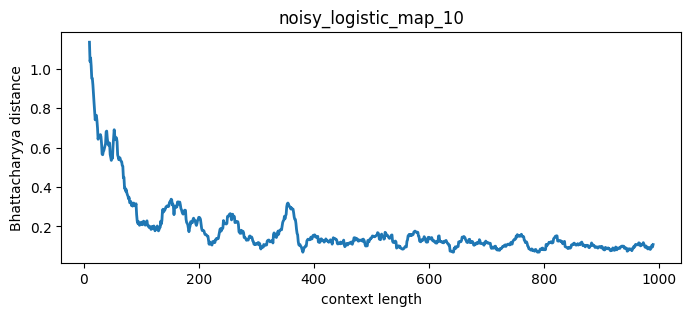

In [12]:
window_size = 20
xlog = 0
ylog = 0

scale_mean_mode_error = 0

top_hat_kernel = np.ones(window_size) / window_size
gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
# kernel = gaussian_kernel
kernel = top_hat_kernel


# Errors from NLL
# averaged_nll_digit = np.convolve(NLL_digit, kernel, mode='valid')

averaged_discrete_BT_loss = np.convolve(discrete_BT_loss, kernel, mode='valid')
# Errors from Bhattacharya distance and KL divergence
BT_loss = error_mean / (rescaled_true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + rescaled_true_sigma_arr) - np.log(sigma_arr * rescaled_true_sigma_arr)/2 - np.log(2)
averaged_BT_loss = np.convolve(BT_loss, kernel, mode='valid')
KL_loss = np.log(sigma_arr/rescaled_true_sigma_arr) + (rescaled_true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2
averaged_KL_loss = np.convolve(KL_loss, kernel, mode='valid')

fig, ax1 = plt.subplots(figsize=(8, 3))

ax1.plot(np.arange(window_size//2, len(discrete_BT_loss) - window_size//2 + 1), averaged_discrete_BT_loss, linewidth=2)

ax1.set_ylabel("Bhattacharyya distance")


# ax2.set_ylim(0,0.5)
if xlog:
    ax1.set_xscale('log')

    
if ylog:
    ax1.set_yscale('log')

    
# plt.xlim(0,150)
    
plt.xlabel("context length")
plt.title(f"{file.stem}")
plt.show()



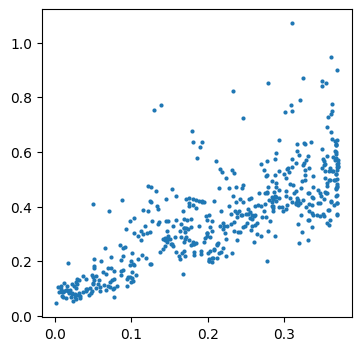

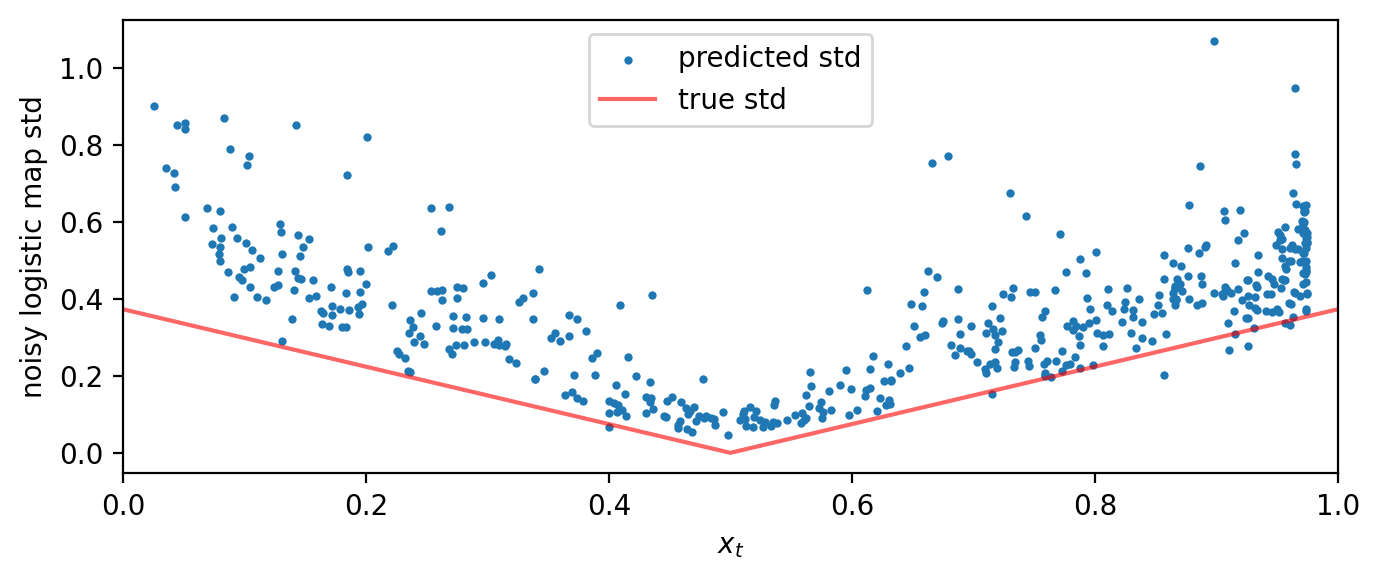

In [13]:
# plt.figure(figsize=(3, 6))
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_true_sigma_arr[500:],sigma_arr[500:], marker='.', lw=0, label = 'predicted sigma')
max_val = np.max(rescaled_true_sigma_arr[500:])
min_val = 0

plt.figure(figsize=(7, 3), dpi = 200)
plt.scatter(time_series[500:-1], sigma_arr[501:], marker = '.', lw=0, label = r'predicted std')
plt.plot([0, 0.5, 1],[rescaled_true_sigma_arr.max(), 0, rescaled_true_sigma_arr.max()], color='red', label = r'true std', linestyle='-', alpha = 0.6)
plt.xlabel(r'$x_t$')
plt.xlim(0,1)
plt.ylabel(r'noisy logistic map std')
plt.legend()
plt.tight_layout()
plt.savefig(f'../figures/noisy_logistic_sigma_temp{alpha}.png')



In [19]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm

### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])


plot1_log_scale = 0
log_scale = 0
discretized_truth = False

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1
    if discretized_truth:
        fig, axs = plt.subplots(3, 1, figsize=(18, 6))
    else:
        fig, axs = plt.subplots(2, 1, figsize=(18, 4))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(time_series, marker='o', color='black', markersize=3, lw = '0.1')
    axs[0].plot(comma_idx-1, time_series[comma_idx-1], color='r', marker='o')
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    # Plot softmax distributions for each digit
    axs[1].set_ylabel("Probability Density") 
    PDF_list[comma_idx].compute_stats()
    PDF_list[comma_idx].plot(ax = axs[1], log_scale=log_scale, statistic = False)
    
    if discretized_truth:
        PDF_true_list[comma_idx].plot(ax = axs[2], log_scale=log_scale)
        axs[2].set_title('discretized truth')
        axs[2].set_xlabel("Digit")
    
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx]
    true_sigma = rescaled_true_sigma_arr[comma_idx]
    x_values = np.linspace(0, 10, 300)
    gaussian = norm.pdf(x_values, true_mean, true_sigma)
    axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth')
    # axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    # axs[1].set_ylim(np.min(pdf.bin_height_arr), np.max(gaussian)*1.7)
    axs[1].legend()
    if log_scale:
        axs[1].set_ylim(0.0005,10)
        if discretized_truth:
            axs[2].set_ylim(0.0005,10)
    # return fig

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(1, num_commas-1, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=999, min=1), Output()), _dom_classes=('w…

<function __main__.digiprob_plotter(comma_idx=1)>

### Temperature Scaling

In [20]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
import copy

save_path = f"../figures/noisy_logistic_example_temperature_scaling.png"

### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
time_series_rescaled = (time_series-time_series.min()) / (time_series.max()-time_series.min()) * (8.5-1.5) + 1.5

plot1_log_scale = 0
log_scale = 0
# final_state = 975
# temp_list = [0.3,0.7,1,3]
temp_list = [1]
final_state = None

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1

    fig, axs = plt.subplots(1+len(temp_list), 1, figsize=(8, 5/3*(1+len(temp_list))), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
    else:
        time_series_plot = time_series_rescaled
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw = '0.1', label = "observation")
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label = "prediction")
    axs[0].set_xlabel('context lenght')
    axs[0].set_ylabel(r'rescaled $x$')
    if final_state is not None:
        axs[0].set_xlim(-10, final_state+10)
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    for i, temp in enumerate(temp_list):
    # Plot softmax distributions for each digit
        axs[i+1].set_ylabel("probability density")
        if len(temp_list) > 1:
            axs[i+1].set_title(f"LLM temperature = {temp}") 
        
        PDF_copied = copy.deepcopy(PDF_list[comma_idx])
        PDF_copied.rescale_temperature(temp)
        PDF_copied.compute_stats()
        PDF_copied.plot(ax = axs[i+1], log_scale=log_scale, statistic = False)

        # characterizing ground truth distribution
        true_mean = rescaled_true_mean_arr[comma_idx]
        true_sigma = rescaled_true_sigma_arr[comma_idx]
        if true_sigma == 0:
            axs[i+1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
        else:
            x_values = np.linspace(0, 10, 300)
            gaussian = norm.pdf(x_values, true_mean, true_sigma)
            axs[i+1].plot(x_values, gaussian, color = 'r', lw = 3, alpha = 0.7)

        # axs[1].bar([0], [0], lw = 3, color='lightseagreen', label='bin of width 1')
        # axs[1].bar([0], [0], lw = 3, color='blue', label='bin of width 0.01')
        axs[1].bar([0], [0], lw = 3, color='dodgerblue', label='LLM prediction')
        axs[1].plot([0], [0], color='r', label='truth')
        
        axs[i+1].set_xlabel(r'rescaled $x$')
        axs[i+1].legend()
        axs[i+1].set_xlim(0,10)
        if len(temp_list) > 1:
            axs[i+1].set_ylim(0,2.6)    
        

    axs[0].legend(loc="upper left")

    if final_state is not None: 
        plt.tight_layout()
        plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
if final_state is not None: 
    interact(digiprob_plotter, comma_idx=final_state)
else:
    interact(digiprob_plotter, comma_idx=(1, num_commas-1, 1))


interactive(children=(IntSlider(value=1, description='comma_idx', max=999, min=1), Output()), _dom_classes=('w…

In [30]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
import copy


### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
time_series_rescaled = (time_series-time_series.min()) / (time_series.max()-time_series.min()) * (8.5-1.5) + 1.5

plot1_log_scale = 0
log_scale = 0
# final_state = 975
# temp_list = [0.3,0.7,1,3]
temp_list = [1]
final_state = None
filenames = []
### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1

    fig, axs = plt.subplots(1+len(temp_list), 1, figsize=(8, 5/3*(1+len(temp_list))), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
    else:
        time_series_plot = time_series_rescaled
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw='0.1', label="observation", zorder=1)
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label="prediction", zorder=2)
    axs[0].set_xlabel('context lenght')
    axs[0].set_ylabel(r'rescaled $x$')
    if final_state is not None:
        axs[0].set_xlim(-10, final_state+10)
    if plot1_log_scale:
        axs[0].set_yscale('log')
    
        
    for i, temp in enumerate(temp_list):
    # Plot softmax distributions for each digit
        axs[i+1].set_ylabel("probability density")
        if len(temp_list) > 1:
            axs[i+1].set_title(f"LLM temperature = {temp}") 
        
        PDF_copied = copy.deepcopy(PDF_list[comma_idx])
        PDF_copied.rescale_temperature(temp)
        PDF_copied.compute_stats()
        PDF_copied.plot(ax = axs[i+1], log_scale=log_scale, statistic = False)
        if log_scale:
            axs[1].set_ylim(0.005,10)

        # characterizing ground truth distribution
        true_mean = rescaled_true_mean_arr[comma_idx]
        true_sigma = rescaled_true_sigma_arr[comma_idx]
        if true_sigma == 0:
            axs[i+1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
        else:
            x_values = np.linspace(0, 10, 300)
            gaussian = norm.pdf(x_values, true_mean, true_sigma)
            axs[i+1].plot(x_values, gaussian, color = 'r', lw = 3, alpha = 0.7)

        # axs[1].bar([0], [0], lw = 3, color='lightseagreen', label='bin of width 1')
        # axs[1].bar([0], [0], lw = 3, color='blue', label='bin of width 0.01')
        axs[1].bar([0], [0], lw = 3, color='dodgerblue', label='LLM prediction')
        axs[1].plot([0], [0], color='r', label='truth')
        
        axs[i+1].set_xlabel(r'rescaled $x$')
        axs[i+1].legend()
        axs[i+1].set_xlim(0,10)
        if len(temp_list) > 1:
            axs[i+1].set_ylim(0,2.6)    
        

    axs[0].legend(loc="upper left")

    plt.tight_layout()
    save_path = f"../figures/noisy_logistic_example_snapshot_{comma_idx}.png"
    filenames.append(save_path)
    plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
# snapshots = [8, 87, 235, 941]
snapshots = [987, 988,989,990,991,992,993,994,995, 996,997,998]
for snapshot in snapshots:
    interact(digiprob_plotter, comma_idx=snapshot)


interactive(children=(IntSlider(value=987, description='comma_idx', max=2961, min=-987), Output()), _dom_class…

interactive(children=(IntSlider(value=988, description='comma_idx', max=2964, min=-988), Output()), _dom_class…

interactive(children=(IntSlider(value=989, description='comma_idx', max=2967, min=-989), Output()), _dom_class…

interactive(children=(IntSlider(value=990, description='comma_idx', max=2970, min=-990), Output()), _dom_class…

interactive(children=(IntSlider(value=991, description='comma_idx', max=2973, min=-991), Output()), _dom_class…

interactive(children=(IntSlider(value=992, description='comma_idx', max=2976, min=-992), Output()), _dom_class…

interactive(children=(IntSlider(value=993, description='comma_idx', max=2979, min=-993), Output()), _dom_class…

interactive(children=(IntSlider(value=994, description='comma_idx', max=2982, min=-994), Output()), _dom_class…

interactive(children=(IntSlider(value=995, description='comma_idx', max=2985, min=-995), Output()), _dom_class…

interactive(children=(IntSlider(value=996, description='comma_idx', max=2988, min=-996), Output()), _dom_class…

interactive(children=(IntSlider(value=997, description='comma_idx', max=2991, min=-997), Output()), _dom_class…

interactive(children=(IntSlider(value=998, description='comma_idx', max=2994, min=-998), Output()), _dom_class…

In [29]:
import imageio.v2 as imageio

with imageio.get_writer('../figures/noisy_logistic_map_snapshots.gif', mode='I', duration=500, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)